# 1. Download the dataset

In [55]:
# fix the error of tqdm module by installing the newest version of it 
#!pip install tqdm==4.63.0


In [4]:
# download dataset
!kaggle datasets download messifor2

100%|█████████████████████████████████████▉| 2.28G/2.29G [00:35<00:00, 46.8MB/s]
100%|██████████████████████████████████████| 2.29G/2.29G [00:43<00:00, 56.6MB/s]


In [7]:
# extract the zip file 
!unzip messidor2-dataset/messifor2.zip

In [1]:
import multiprocessing
from multiprocessing.pool import ThreadPool
print(multiprocessing.cpu_count()," CPU cores")

6  CPU cores


In [2]:
# Apply image preprocessing steps to hole dataset
IMG_SIZE = 320

def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img

def circle_crop(img, sigmaX = 30):   
    """
    Create circular crop around image centre    
    """    
    img = crop_image_from_gray(img)    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    height, width, depth = img.shape    
    
    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))
    
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    img=cv2.addWeighted(img, 4, cv2.GaussianBlur( img , (0,0) , sigmaX) ,-4 ,128)
    return img 

def preprocess_image(file):
    input_filepath = '{}'.format(file)
    output_filepath = os.path.join('messidor2', 'messidor_processed', '{}'.format(file.split('/')[-1]))
    
    img = cv2.imread(input_filepath)
    img = circle_crop(img) 
    cv2.imwrite(output_filepath, cv2.resize(img, (IMG_SIZE,IMG_SIZE)))

In [3]:
def multiprocess_image_processor(process:int, imgs:list):
    """
    Inputs:
        process: (int) number of process to run
        imgs:(list) list of images
    """
    print(f'MESSAGE: Running {process} process')
    ThreadPool(process).map(preprocess_image, imgs)

In [106]:
imgs = os.listdir('messidor2/IMAGES/')
imgs = list(map(lambda x: os.path.join('messidor2', 'IMAGES', '{}'.format(x)), imgs))

In [110]:
multiprocess_image_processor(6, imgs)

# 2. Feature Extraction with DL
* Load the ResNet50 model, and get the last cnn layer as output layer.
* feed the images through the model and get the features of each image.

In [2]:
import warnings
warnings.simplefilter('ignore')
import cv2
%matplotlib inline  
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL.Image
import keras
import keras.backend
import keras.layers
import keras.models
import keras.utils
from keras import backend as K
from keras.datasets import mnist
from keras.layers import Activation, Dense, Dropout, Input
from keras.models import Model
from keras.layers import Input, Lambda, Dense, Flatten, Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D, BatchNormalization
from keras.models import Model
from keras.applications import ResNet50
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model

Using TensorFlow backend.


In [3]:
from tqdm.notebook import tqdm

In [4]:
model = load_model('../ToKaggle/ResNetV2.h5')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



## Get only feature extraction layers from the model 
* drop last 4 layers 

In [13]:
feature_extraction_model = Model(inputs=model.input,
                                 outputs=model.layers[-2].output)
feature_extraction_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 320, 320, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 326, 326, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 160, 160, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 160, 160, 64) 256         conv1[0][0]                      
____________________________________________________________________________________________

In [63]:
def images_to_vector(images:list, feature_extraction_model: Model):
    """
    loop for each image in a dataset and extract feautures form it using a deep learning model
    :param paths: list of paths to dataset 
    :param paths: image_id (path) of each image in dataset , list of string  
    :param feature_extraction_model: deep learning model used in feature extraction process.
    :param model: deep learning model used in prediction process.
    """
    # resutl is a list of vectors each vector represents the features extracted form an image
    result = []
    for i in tqdm(range(len(images))):
        try:
            image = cv2.imread(images[i])
            image = cv2.resize(image, (320, 320))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = image / 255 
            # vector = 2048 feature
            x = feature_extraction_model.predict(image[None])
            result.append(x.flatten())
        except:
            print(images[i])
    return result

In [28]:
def predication(images:list, model: Model):
    # resutl is a list of vectors each vector represents the features extracted form an image
    result = []
    for i in tqdm(range(len(images))):
        try:
            image = cv2.imread(images[i])
            image = cv2.resize(image, (320, 320))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = image / 255 
            y = model.predict(image[None])
            result.append(np.argmax(y))
        except:
            print(images[i])
    return result

In [1]:
import tensorflow as tf
print(tf.__version__)

2.3.1


## 2. Extract features from each dataset using feature_extraction model 
* Apply feature extraction to train&test kaggle dataset 
* Apply feature extraction to messidor dataset

In [ ]:
# apply feature extraction to training dataset (Kaggle)
trainset_images = []
for i in range(5):
    imgs = os.listdir(os.path.join('..', 'dataset', 'processed_train', 'class_{}'.format(i)))
    imgs = list(map(lambda x: os.path.join('..', 'dataset', 'processed_train', 'class_{}'.format(i), x), imgs))
    trainset_images += imgs 
trainset_images

In [62]:
trainset_images = trainset_images[18000:]

In [65]:
for i in range(5):
    imgs = os.listdir(os.path.join('..', 'dataset', 'processed_train', 'class_{}'.format(i)))
    print(len(imgs))

20907
1978
4287
707
573


In [64]:
trainset_vectors = images_to_vector(trainset_images, feature_extraction_model)

  0%|          | 0/10452 [00:00<?, ?it/s]

../dataset/processed_train/class_0/temp


In [17]:
# apply feature extraction to testset kaggle data
test_set_paths = [os.path.join('..', 'dataset', 'processed_test', 'class_{}'.format(i)) for i in range(5)]
print(test_set_paths)

['../dataset/processed_test/class_0', '../dataset/processed_test/class_1', '../dataset/processed_test/class_2', '../dataset/processed_test/class_3', '../dataset/processed_test/class_4']


In [19]:
testset_images = []
for i in range(5):
    imgs = os.listdir(os.path.join('..', 'dataset', 'processed_test', 'class_{}'.format(i)))
    imgs = list(map(lambda x: os.path.join('..', 'dataset', 'processed_test', 'class_{}'.format(i), x), imgs))
    testset_images += imgs 

In [24]:
testset_as_vectors = images_to_vector(testset_images, feature_extraction_model)

In [82]:
# save the features to binary file using pickle module 
import pickle 

with open('../dataset/trainset_as_vectors.pkl', 'wb') as output_file:
    pickle.dump(trainset_vectors, output_file )

with open('../dataset/testset_as_vectors.pkl', 'wb') as output_file:
    pickle.dump(testset_as_vectors, output_file)

In [26]:
with open('../dataset/trainset_as_vectors.pkl', 'rb') as in_file:
    trainset_vectors = pickle.load(in_file)

In [27]:
print('Number of features extracted from an image : {}'.format(feature_vectors[0].shape))

Number of features extracted from an image : (1, 2048)


In [23]:
import pandas as pd 


df = pd.read_csv('../messidor2/messidor_data.csv')
df.head()

,image_id,adjudicated_dr_grade,adjudicated_dme,adjudicated_gradable
0,20051020_43808_0100_PP.png,0.0,0.0,1
1,20051020_43832_0100_PP.png,1.0,0.0,1
2,20051020_43882_0100_PP.png,1.0,0.0,1
3,20051020_43906_0100_PP.png,2.0,1.0,1
4,20051020_44261_0100_PP.png,0.0,0.0,1


In [24]:
df['image_id'] = df['image_id'].apply(lambda x: x.upper() if x[-3:] == 'jpg' else x)
df['image_exist'] = df['image_id'].apply(lambda x: os.path.exists(os.path.join('..', 'messidor2', 'messidor_processed', x)))
df.fillna(0, inplace=True)
df.isnull().sum()

image_id                0
adjudicated_dr_grade    0
adjudicated_dme         0
adjudicated_gradable    0
image_exist             0
dtype: int64

In [25]:
df.head()

,image_id,adjudicated_dr_grade,adjudicated_dme,adjudicated_gradable,image_exist
0,20051020_43808_0100_PP.png,0.0,0.0,1,True
1,20051020_43832_0100_PP.png,1.0,0.0,1,True
2,20051020_43882_0100_PP.png,1.0,0.0,1,True
3,20051020_43906_0100_PP.png,2.0,1.0,1,True
4,20051020_44261_0100_PP.png,0.0,0.0,1,True


In [14]:
y_true = df['adjudicated_dr_grade'].astype('int').tolist()

In [15]:
y_true = np.array(y_true)

In [26]:
df['image_exist'].value_counts()

True    1748
Name: image_exist, dtype: int64

In [33]:
df['adjudicated_dr_grade'].value_counts()

0.0    1021
2.0     347
1.0     270
3.0      75
4.0      35
Name: adjudicated_dr_grade, dtype: int64

In [27]:
messidor_images = df['image_id']
messidor_images = list(map(lambda x: os.path.join('..', 'messidor2', 'messidor_processed', x) , messidor_images))
messidor_images[0]

'../messidor2/messidor_processed/20051020_43808_0100_PP.png'

In [29]:
messidor_y_pred = predication(messidor_images, model)

  0%|          | 0/1748 [00:00<?, ?it/s]

In [30]:
acc_score = lambda y, y_pred: np.sum(np.equal(y, messidor_y_pred)) / len(y)

In [31]:
print('Accuracy on messidor2 dataset {}'.format(acc_score(y_true, messidor_y_pred)))

Accuracy on messidor2 dataset 0.7299771167048055


In [32]:
from sklearn.metrics import classification_report
labels = ['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe', '4 - Proliferative DR']
print(classification_report(y_true, messidor_y_pred, target_names=labels))

                      precision    recall  f1-score   support

           0 - No DR       0.74      0.97      0.84      1021
            1 - Mild       0.23      0.02      0.03       270
        2 - Moderate       0.72      0.63      0.67       347
          3 - Severe       0.80      0.59      0.68        75
4 - Proliferative DR       0.88      0.40      0.55        35

            accuracy                           0.73      1748
           macro avg       0.67      0.52      0.55      1748
        weighted avg       0.66      0.73      0.67      1748



## 3. Train Machine leanring models using feature extracted from the model
* Train different machine learnign models on kaggle  training datast 
* Evaluate each model using testset kaggle& messidor2 datasets

In [46]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import seaborn as sns 
from sklearn.neighbors import KNeighborsClassifier
from IPython.display import display

In [80]:
def generate_classifiers():
    """
    Generate list of machine learning models
    """
    classifiers = [
        svm.SVC(decision_function_shape='ovo', max_iter=10000, C=0.7, probability=True), 
        svm.SVC(kernel='rbf', max_iter=8000, C=100, probability=True),
        svm.SVC(kernel='poly', max_iter=5000, degree=5, coef0=1, C=50, probability=True),
        svm.SVC(kernel='linear', max_iter=5000, C=100, probability=True),
        KNeighborsClassifier(5),
        KNeighborsClassifier(13, weights='distance'),
        KNeighborsClassifier(7, algorithm='kd_tree'),
        LogisticRegression(penalty='l1', solver='saga', max_iter=600, l1_ratio=0.2),
        LogisticRegression(penalty='l2', solver='sag', max_iter=700), 
        DecisionTreeClassifier(),
        LogisticRegression(penalty='elasticnet', solver='saga', max_iter=800, l1_ratio=0.4), 
        DecisionTreeClassifier(max_depth=8, min_samples_leaf=15, random_state=42, max_features=20),
        DecisionTreeClassifier(max_depth=9, min_samples_leaf=35, random_state=42, max_features=50),
        DecisionTreeClassifier(max_depth=10, min_samples_leaf=28, max_features=200, random_state=42),
        GaussianNB(),
        RandomForestClassifier(n_estimators=40, max_depth=8, random_state=0, max_leaf_nodes=30),
        RandomForestClassifier(),
        RandomForestClassifier(max_depth=15, random_state=42),
        RandomForestClassifier(n_estimators=60, max_depth=10, max_leaf_nodes=100),
        RandomForestClassifier(n_estimators=50, max_depth=8, max_leaf_nodes=50),
        XGBClassifier(learning_rate= 0.3, max_depth= 8, n_estimators= 40, subsample= 0.7),
        XGBClassifier(learning_rate= 0.2, max_depth= 10, n_estimators= 30, subsample= 0.5),
    ]
    return classifiers

In [31]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import classification_report


def train_and_test(classifier, X_train, X_test, y_train, y_test):
    print(classifier)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    y_score = classifier.predict_proba(X_test)[:,1]
    
    
    train_accuracy = classifier.score(X_train, y_train)
    accuracy = classifier.score(X_test, y_test)
    classification_rep = classification_report(y_test, y_pred)
    con_matrix = confusion_matrix(y_test, y_pred)

    # ploting confustion matrix
    plt.figure(figsize=(12,12))
    plt.subplot(2,1,1)
    sns.heatmap(np.round(con_matrix / con_matrix.sum(axis=0), 2), annot=True, annot_kws={"size": 16},fmt='g', cmap='Blues')
    plt.ylabel("Real value")
    plt.xlabel("Predicted value")
    plt.show()

    # print scores
    print ("accuracy  score on train : {}".format(train_accuracy))
    print ("accuracy  score on test : {}".format(accuracy))
    print(classification_rep)

# 3.1 Kaggle Dataset
* Train list of machine learning classifiers on Kaggle dataset
* predict on tesetset images 

In [67]:
X_train_kaggle = np.array(trainset_vectors)

# number of samples from each class in training dataset 
num_of_samples = [20907 - 18001, 1978, 4287, 707, 573]

y_train_kaggle = []
for i, num in enumerate(num_of_samples):
    y_train_kaggle += [i] * num
y_train_kaggle = np.array(y_train_kaggle)

print('X_train shape : {}'.format(X_train_kaggle.shape))
print('y_train shape : {}'.format(y_train_kaggle.shape))

X_train shape : (10451, 2048)
y_train shape : (10451,)


In [68]:
X_test_kaggle = np.array(testset_as_vectors)

y_test_kaggle = []
for i in range(5):
    imgs = os.listdir(os.path.join('..', 'dataset', 'processed_test', 'class_{}'.format(i)))
    y_test_kaggle += [i] * len(imgs)
y_test_kaggle = np.array(y_test_kaggle)


print('X_test shape : {}'.format(X_test_kaggle.shape))
print('y_test shape : {}'.format(y_test_kaggle.shape))

X_test shape : (3513, 2048)
y_test shape : (3513,)


SVC(C=0.7, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovo', degree=3, gamma='scale', kernel='rbf',
    max_iter=10000, probability=True, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


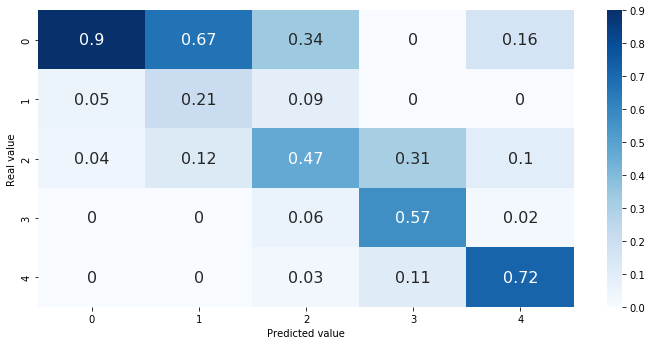

accuracy  score on train : 0.6590756865371735
accuracy  score on test : 0.7569029319669798
              precision    recall  f1-score   support

           0       0.90      0.84      0.87      2581
           1       0.21      0.16      0.18       245
           2       0.47      0.73      0.57       529
           3       0.57      0.36      0.44        87
           4       0.72      0.51      0.60        71

    accuracy                           0.76      3513
   macro avg       0.58      0.52      0.53      3513
weighted avg       0.78      0.76      0.76      3513



None

SVC(C=0.9, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=8000, probability=True, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


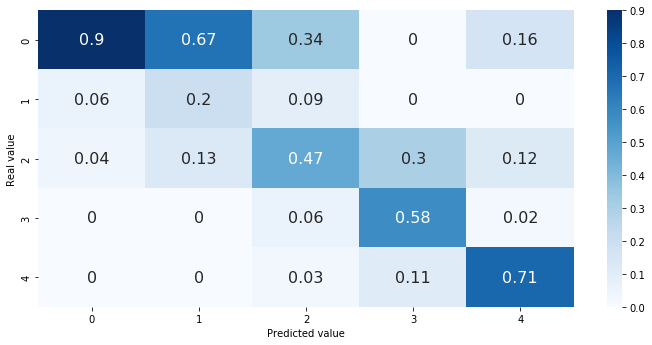

accuracy  score on train : 0.6613721175007177
accuracy  score on test : 0.7551949900370054
              precision    recall  f1-score   support

           0       0.90      0.84      0.87      2581
           1       0.20      0.16      0.18       245
           2       0.47      0.72      0.57       529
           3       0.58      0.36      0.44        87
           4       0.71      0.51      0.59        71

    accuracy                           0.76      3513
   macro avg       0.57      0.52      0.53      3513
weighted avg       0.78      0.76      0.76      3513



None

SVC(C=0.8, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=5000, probability=True, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


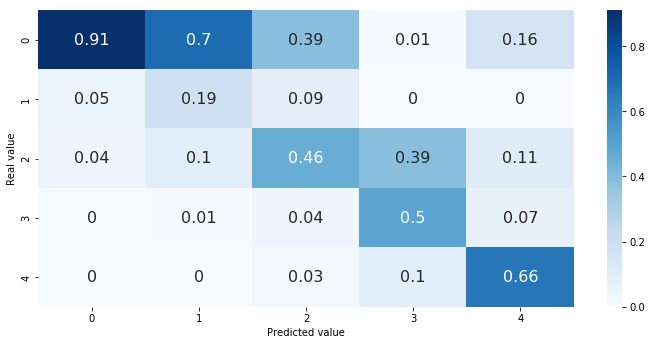

accuracy  score on train : 0.7150511912735623
accuracy  score on test : 0.7190435525192144
              precision    recall  f1-score   support

           0       0.91      0.78      0.84      2581
           1       0.19      0.27      0.22       245
           2       0.46      0.70      0.55       529
           3       0.50      0.53      0.51        87
           4       0.66      0.52      0.58        71

    accuracy                           0.72      3513
   macro avg       0.54      0.56      0.54      3513
weighted avg       0.78      0.72      0.74      3513



None

SVC(C=0.2, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=5000, probability=True, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


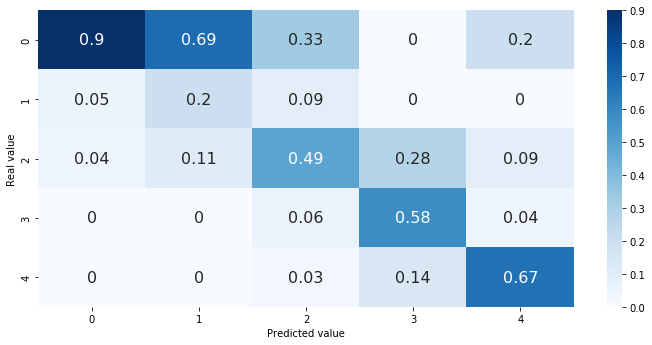

accuracy  score on train : 0.6846234810066022
accuracy  score on test : 0.7517791061770567
              precision    recall  f1-score   support

           0       0.90      0.83      0.86      2581
           1       0.20      0.21      0.20       245
           2       0.49      0.73      0.59       529
           3       0.58      0.38      0.46        87
           4       0.67      0.51      0.58        71

    accuracy                           0.75      3513
   macro avg       0.57      0.53      0.54      3513
weighted avg       0.78      0.75      0.76      3513



None

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')


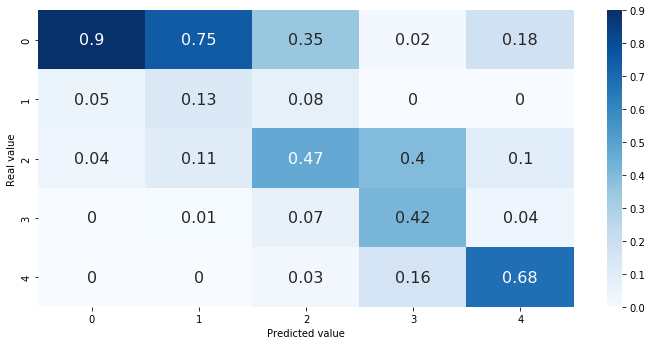

accuracy  score on train : 0.7177303607310305
accuracy  score on test : 0.6831767719897524
              precision    recall  f1-score   support

           0       0.90      0.74      0.82      2581
           1       0.13      0.27      0.17       245
           2       0.47      0.67      0.55       529
           3       0.42      0.30      0.35        87
           4       0.68      0.48      0.56        71

    accuracy                           0.68      3513
   macro avg       0.52      0.49      0.49      3513
weighted avg       0.77      0.68      0.71      3513



None

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=13, p=2,
                     weights='distance')


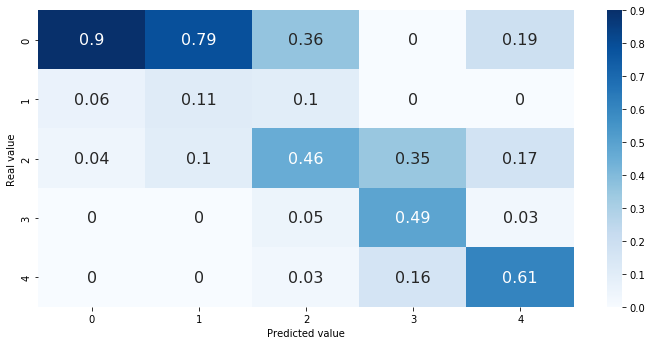

accuracy  score on train : 1.0
accuracy  score on test : 0.6888699117563336
              precision    recall  f1-score   support

           0       0.90      0.75      0.82      2581
           1       0.11      0.20      0.14       245
           2       0.46      0.69      0.55       529
           3       0.49      0.43      0.46        87
           4       0.61      0.51      0.55        71

    accuracy                           0.69      3513
   macro avg       0.51      0.51      0.50      3513
weighted avg       0.76      0.69      0.72      3513



None

KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=7, p=2,
                     weights='uniform')


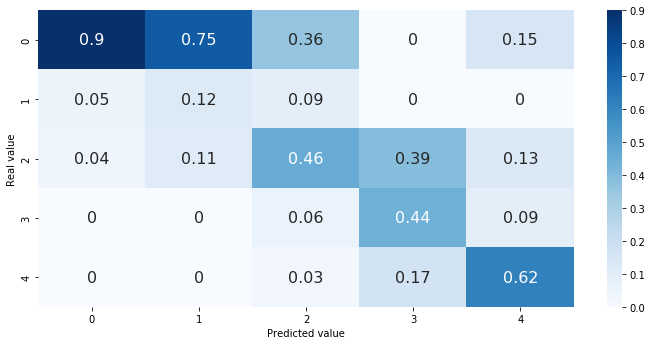

accuracy  score on train : 0.7024208209740694
accuracy  score on test : 0.6808995160831198
              precision    recall  f1-score   support

           0       0.90      0.74      0.81      2581
           1       0.12      0.26      0.17       245
           2       0.46      0.67      0.55       529
           3       0.44      0.36      0.39        87
           4       0.62      0.46      0.53        71

    accuracy                           0.68      3513
   macro avg       0.51      0.50      0.49      3513
weighted avg       0.76      0.68      0.71      3513



None

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=0.2, max_iter=600,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)


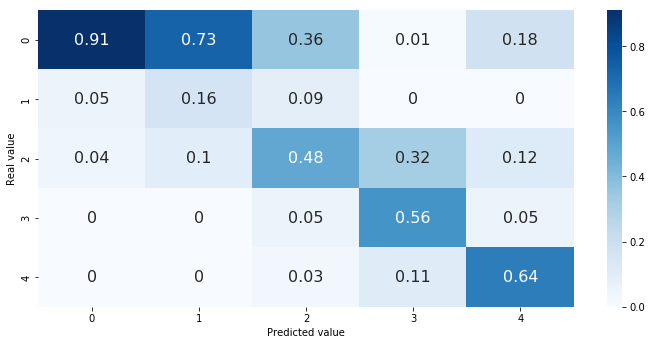

accuracy  score on train : 0.7221318534111568
accuracy  score on test : 0.7105038428693424
              precision    recall  f1-score   support

           0       0.91      0.76      0.83      2581
           1       0.16      0.29      0.21       245
           2       0.48      0.71      0.57       529
           3       0.56      0.47      0.51        87
           4       0.64      0.51      0.57        71

    accuracy                           0.71      3513
   macro avg       0.55      0.55      0.54      3513
weighted avg       0.78      0.71      0.74      3513



None

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')


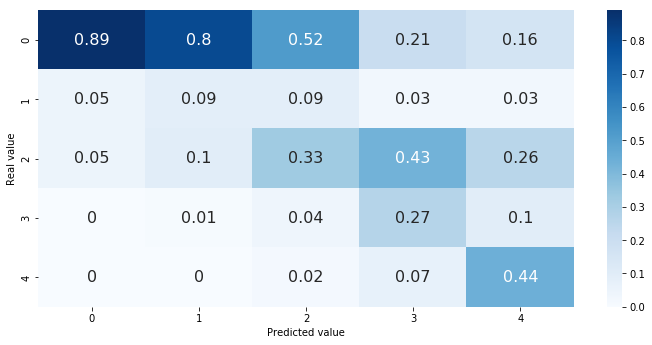

accuracy  score on train : 1.0
accuracy  score on test : 0.5311699402220325
              precision    recall  f1-score   support

           0       0.89      0.55      0.68      2581
           1       0.09      0.32      0.15       245
           2       0.33      0.54      0.41       529
           3       0.27      0.41      0.33        87
           4       0.44      0.55      0.49        71

    accuracy                           0.53      3513
   macro avg       0.41      0.47      0.41      3513
weighted avg       0.73      0.53      0.59      3513



None

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=0.4, max_iter=800,
                   multi_class='auto', n_jobs=None, penalty='elasticnet',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)


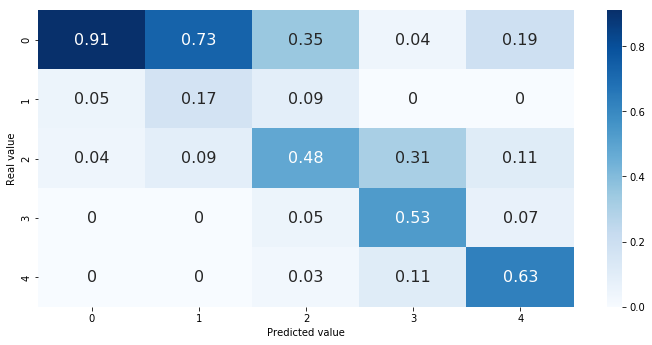

accuracy  score on train : 0.7046215673141326
accuracy  score on test : 0.7164816396242528
              precision    recall  f1-score   support

           0       0.91      0.77      0.84      2581
           1       0.17      0.29      0.22       245
           2       0.48      0.71      0.57       529
           3       0.53      0.43      0.47        87
           4       0.63      0.51      0.56        71

    accuracy                           0.72      3513
   macro avg       0.54      0.54      0.53      3513
weighted avg       0.78      0.72      0.74      3513



None

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=8, max_features=20, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=15, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')


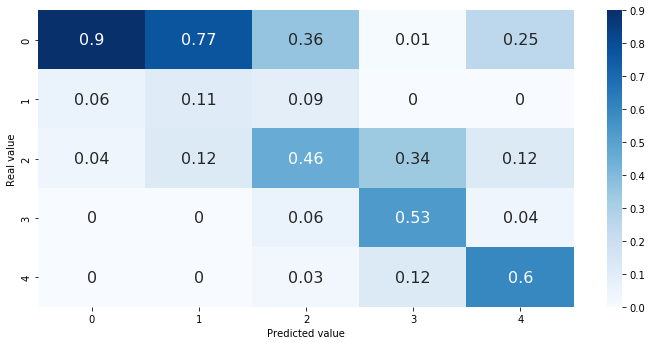

accuracy  score on train : 0.6829968424074251
accuracy  score on test : 0.6914318246512952
              precision    recall  f1-score   support

           0       0.90      0.75      0.82      2581
           1       0.11      0.19      0.14       245
           2       0.46      0.69      0.55       529
           3       0.53      0.41      0.46        87
           4       0.60      0.48      0.53        71

    accuracy                           0.69      3513
   macro avg       0.52      0.51      0.50      3513
weighted avg       0.76      0.69      0.72      3513



None

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=9, max_features=50, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=35, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')


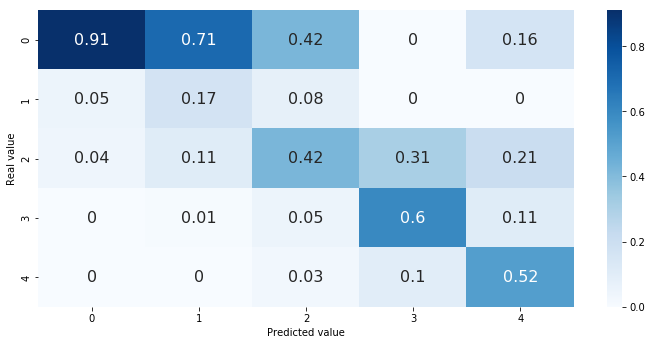

accuracy  score on train : 0.6803176729499569
accuracy  score on test : 0.6931397665812695
              precision    recall  f1-score   support

           0       0.91      0.75      0.82      2581
           1       0.17      0.24      0.20       245
           2       0.42      0.70      0.52       529
           3       0.60      0.36      0.45        87
           4       0.52      0.55      0.53        71

    accuracy                           0.69      3513
   macro avg       0.52      0.52      0.50      3513
weighted avg       0.76      0.69      0.72      3513



None

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=10, max_features=200, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=28, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')


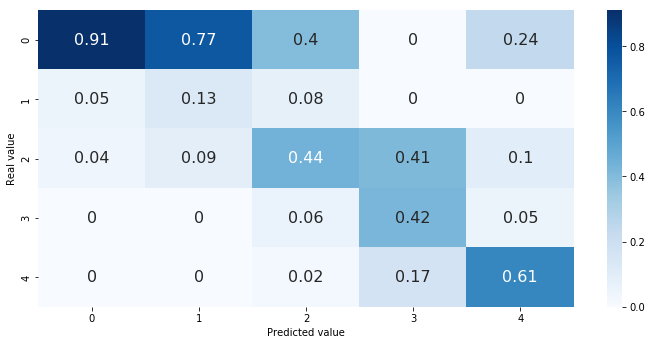

accuracy  score on train : 0.7109367524638791
accuracy  score on test : 0.6623968118417307
              precision    recall  f1-score   support

           0       0.91      0.70      0.79      2581
           1       0.13      0.29      0.18       245
           2       0.44      0.71      0.54       529
           3       0.42      0.33      0.37        87
           4       0.61      0.51      0.55        71

    accuracy                           0.66      3513
   macro avg       0.50      0.51      0.49      3513
weighted avg       0.77      0.66      0.70      3513



None

GaussianNB(priors=None, var_smoothing=1e-09)


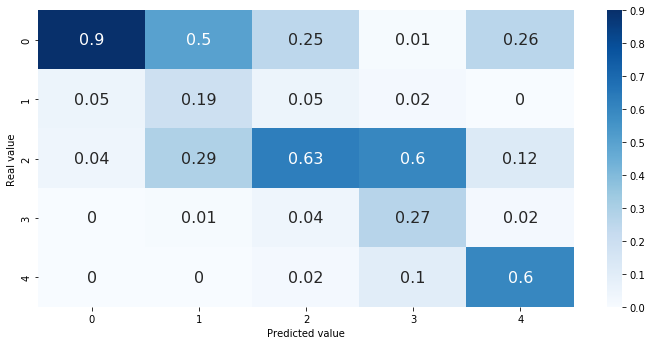

accuracy  score on train : 0.4999521576882595
accuracy  score on test : 0.7324224309706804
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      2581
           1       0.19      0.39      0.25       245
           2       0.63      0.20      0.30       529
           3       0.27      0.82      0.40        87
           4       0.60      0.49      0.54        71

    accuracy                           0.73      3513
   macro avg       0.52      0.55      0.48      3513
weighted avg       0.79      0.73      0.74      3513



None

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8, max_features='auto',
                       max_leaf_nodes=30, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=40,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)


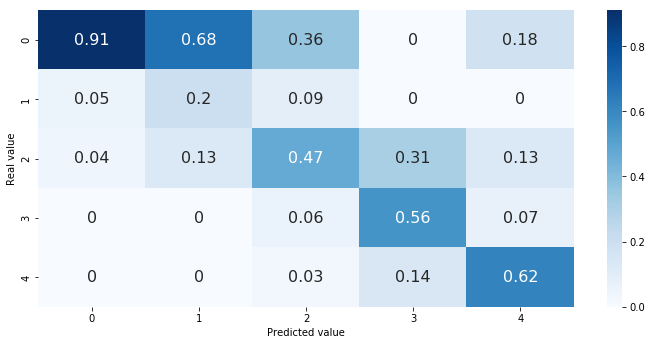

accuracy  score on train : 0.6751507032819826
accuracy  score on test : 0.740392826643894
              precision    recall  f1-score   support

           0       0.91      0.81      0.86      2581
           1       0.20      0.22      0.21       245
           2       0.47      0.72      0.57       529
           3       0.56      0.38      0.45        87
           4       0.62      0.54      0.58        71

    accuracy                           0.74      3513
   macro avg       0.55      0.53      0.53      3513
weighted avg       0.78      0.74      0.75      3513



None

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


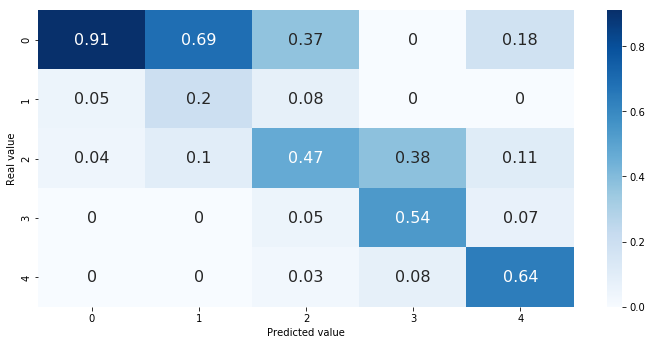

accuracy  score on train : 1.0
accuracy  score on test : 0.7250213492741246
              precision    recall  f1-score   support

           0       0.91      0.78      0.84      2581
           1       0.20      0.30      0.24       245
           2       0.47      0.72      0.57       529
           3       0.54      0.40      0.46        87
           4       0.64      0.55      0.59        71

    accuracy                           0.73      3513
   macro avg       0.55      0.55      0.54      3513
weighted avg       0.78      0.73      0.74      3513



None

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=15, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)


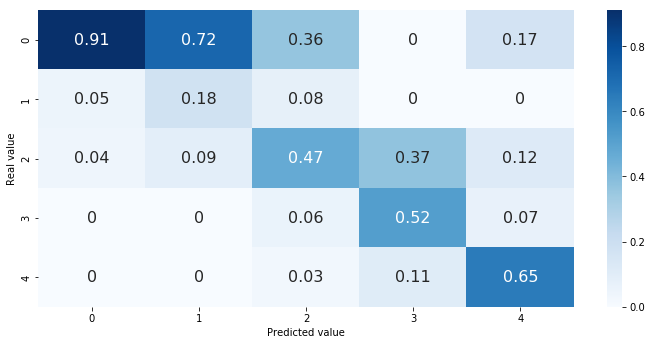

accuracy  score on train : 0.957611711797914
accuracy  score on test : 0.71733561058924
              precision    recall  f1-score   support

           0       0.91      0.77      0.84      2581
           1       0.18      0.29      0.22       245
           2       0.47      0.72      0.57       529
           3       0.52      0.38      0.44        87
           4       0.65      0.55      0.60        71

    accuracy                           0.72      3513
   macro avg       0.55      0.54      0.53      3513
weighted avg       0.78      0.72      0.74      3513



None

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=100, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=60,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


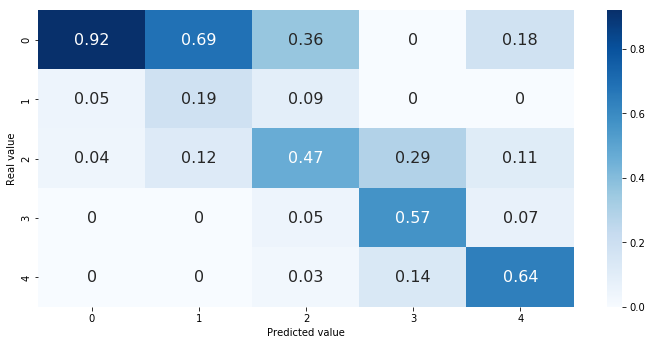

accuracy  score on train : 0.7225145919050808
accuracy  score on test : 0.7307144890407059
              precision    recall  f1-score   support

           0       0.92      0.79      0.85      2581
           1       0.19      0.27      0.22       245
           2       0.47      0.73      0.57       529
           3       0.57      0.41      0.48        87
           4       0.64      0.55      0.59        71

    accuracy                           0.73      3513
   macro avg       0.56      0.55      0.54      3513
weighted avg       0.78      0.73      0.75      3513



None

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8, max_features='auto',
                       max_leaf_nodes=50, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


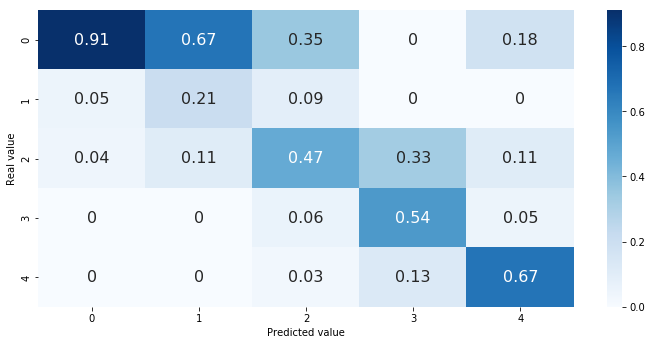

accuracy  score on train : 0.6902688737919817
accuracy  score on test : 0.7418161115855394
              precision    recall  f1-score   support

           0       0.91      0.81      0.86      2581
           1       0.21      0.25      0.23       245
           2       0.47      0.73      0.57       529
           3       0.54      0.39      0.45        87
           4       0.67      0.54      0.59        71

    accuracy                           0.74      3513
   macro avg       0.56      0.54      0.54      3513
weighted avg       0.78      0.74      0.76      3513



None

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.3, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=None, n_estimators=40, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.7, verbosity=1)


In [ ]:
classifiers = generate_classifiers()
for clf in classifiers:
    display(train_and_test(clf, X_train_kaggle, X_test_kaggle, y_train_kaggle, y_test_kaggle))

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.3, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=None, n_estimators=40, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.7, verbosity=1)


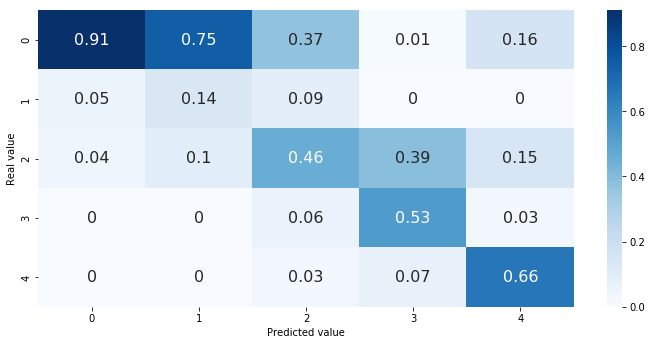

accuracy  score on train : 0.999617261506076
accuracy  score on test : 0.6894392257329918
              precision    recall  f1-score   support

           0       0.91      0.74      0.82      2581
           1       0.14      0.29      0.19       245
           2       0.46      0.69      0.55       529
           3       0.53      0.43      0.47        87
           4       0.66      0.56      0.61        71

    accuracy                           0.69      3513
   macro avg       0.54      0.54      0.53      3513
weighted avg       0.77      0.69      0.72      3513



None

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.2, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=None, n_estimators=30, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.5, verbosity=1)


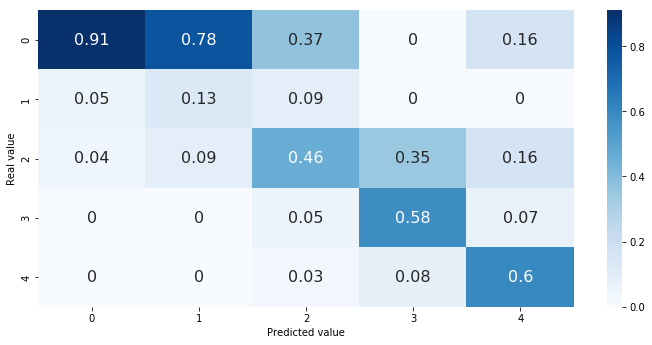

accuracy  score on train : 0.9770356903645584
accuracy  score on test : 0.6885852547680046
              precision    recall  f1-score   support

           0       0.91      0.74      0.81      2581
           1       0.13      0.26      0.18       245
           2       0.46      0.71      0.56       529
           3       0.58      0.44      0.50        87
           4       0.60      0.58      0.59        71

    accuracy                           0.69      3513
   macro avg       0.54      0.54      0.53      3513
weighted avg       0.77      0.69      0.72      3513



None

In [72]:
classifiers = generate_classifiers()[-2:]
for clf in classifiers:
    display(train_and_test(clf, X_train_kaggle, X_test_kaggle, y_train_kaggle, y_test_kaggle))

SVC(C=100, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=8000, probability=True, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


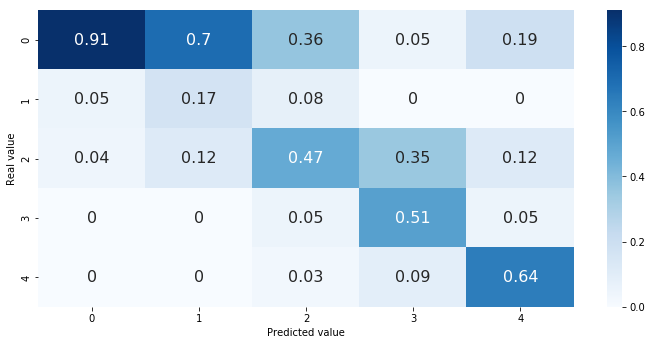

accuracy  score on train : 0.8058558989570376
accuracy  score on test : 0.7107884998576715
              precision    recall  f1-score   support

           0       0.91      0.77      0.83      2581
           1       0.17      0.30      0.22       245
           2       0.47      0.69      0.56       529
           3       0.51      0.45      0.48        87
           4       0.64      0.54      0.58        71

    accuracy                           0.71      3513
   macro avg       0.54      0.55      0.53      3513
weighted avg       0.78      0.71      0.74      3513



None

SVC(C=50, break_ties=False, cache_size=200, class_weight=None, coef0=1,
    decision_function_shape='ovr', degree=5, gamma='scale', kernel='poly',
    max_iter=5000, probability=True, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


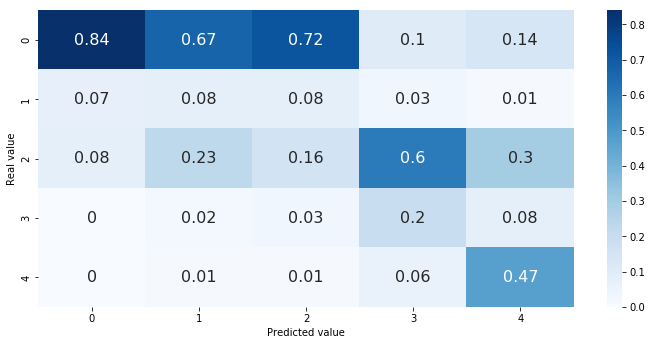

accuracy  score on train : 0.478614486651995
accuracy  score on test : 0.515798462852263
              precision    recall  f1-score   support

           0       0.84      0.60      0.70      2581
           1       0.08      0.11      0.09       245
           2       0.16      0.32      0.21       529
           3       0.20      0.39      0.27        87
           4       0.47      0.59      0.52        71

    accuracy                           0.52      3513
   macro avg       0.35      0.40      0.36      3513
weighted avg       0.66      0.52      0.57      3513



None

SVC(C=100, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=5000, probability=True, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


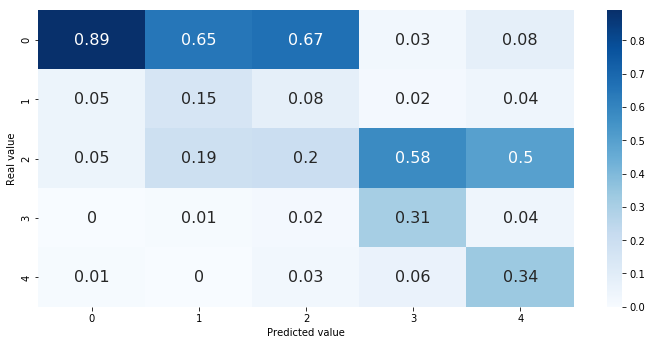

accuracy  score on train : 0.5018658501578797
accuracy  score on test : 0.5294619982920581
              precision    recall  f1-score   support

           0       0.89      0.57      0.70      2581
           1       0.15      0.27      0.19       245
           2       0.20      0.46      0.28       529
           3       0.31      0.61      0.41        87
           4       0.34      0.24      0.28        71

    accuracy                           0.53      3513
   macro avg       0.38      0.43      0.37      3513
weighted avg       0.71      0.53      0.59      3513



None

In [81]:
classifiers = generate_classifiers()[1:4]
for clf in classifiers:
    display(train_and_test(clf, X_train_kaggle, X_test_kaggle, y_train_kaggle, y_test_kaggle))

# 3.2 Messidor dataset
* Use the same training dataset 
* Evaluate using messidor dataset